<a href="https://colab.research.google.com/github/sampso29/Power-Consumption-Clustering/blob/main/W4_Clustering_Assignment(GoogleColab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important Notes:

---
1- Due to file size, you are unable to run this notebook using default runtime setting. You need to switch to TPU or GPU to be able to import data.  Learn more about TPU (Tensorflow Processing Unit) or GPU  [here](https://en.wikipedia.org/wiki/Tensor_processing_unit)  and  [here](https://en.wikipedia.org/wiki/Graphics_processing_unit) respectively. You can see the benfit of TPU [here](https://cloud.google.com/tpu/))

# Follow below steps to change your default runtime:
* From menu bar, open "Runtime"
* Navigate to "Change Runtime Type"

[See this screenshot](https://drive.google.com/open?id=1up4zIBrXk6P0eNcQIZ5MxygN6A8TWB0s)
* And change your "Hardware Accelerator" to "TPU" or "GPU"
* Hit "Save"


---


2- Do not make direct changes into this file. Create your own file. How? Follow below instructions

**Instructios to create your copy**

*   From this Notebook, go to **"File"**  menu
*   select "**Save a copy in Drive**". 
*   Find the file in your "**Colab Notebook**" folders in your Google Drive root
*   Create a copy for yourself by right clicking on the file name and selecting "**Make a COPY**"
*   Rename it by replacing your last name and UTORid and move the notebook if you need. Develop the code. 
*   Once you finish the code, get shareable URL (use this  [Guide ](https://support.google.com/drive/answer/2494822?co=GENIE.Platform%3DDesktop&hl=en)  from Google if you need for your notebook and submit it as part of your assignment submission.

Make sure I have Edit access to your notebook when sharing so I can leave remarks if needed.

Once complete this notebook, respond to the questions in the Quiz section

# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

### Import CSV into Google Colab.
If you do not remember how, you can refer to this document

In [216]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [217]:
import fileinput

# Review below URL and make sure the URL points to the folder in your drive where you have the file named "LD2011_2014.txt".
# Please use the datafile from the Shared Folder that I have created named "Shared_Drop_Box_UoT_3253_ML_Saeid_Abolfazli". If you do  
# download it from server (follow the URL provided in the first text cell in this Notebook), upload it to your Drive, Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
# and load it here. 
# Send me email if you have question so I can help!


import os
import zipfile
from six.moves import urllib
import pandas as pd
import fileinput

ZIP_NAME = "LD2011_2014.txt.zip"
DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/"
DATASET_PATH = os.path.join("datasets", "Electricity_Load")
DATASET_URL = DOWNLOAD_ROOT + ZIP_NAME
FILE_NAME = "LD2011_2014.txt"

In [218]:
def Electricity_Data(DATASET_url=DATASET_URL, DATASET_path=DATASET_PATH):
    if not os.path.isdir(DATASET_path):
        os.makedirs(DATASET_path)
    file_path = os.path.join(DATASET_path,ZIP_NAME)
    
    urllib.request.urlretrieve(DATASET_URL, file_path) 
    # The commented code above wont execute in proxy settings. Please download the files from UCI
    # https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#
    Electric_zip = zipfile.ZipFile(file_path, 'r')
    Electric_zip.extractall(DATASET_path)  
    Electric_zip.close()

# Ran the code only once - Since the file is too large - The function call is commented out.
Electricity_Data()

In [219]:
def load_Electricity_data(dataset_path=DATASET_PATH):
    file_path = os.path.join(dataset_path,FILE_NAME)
    with fileinput.FileInput(file_path, inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace(",", "."), end='')
    return pd.read_csv(file_path, sep=";", index_col=0)
    
data = load_Electricity_data()
#fileName = 'LD2011_2014.txt'

In [220]:
# To ensure you have the right data, make sure your data.shape output is (140256, 370). 
# Otherwise, you data file is corrupt and have to read data again. Copy the original file from Saeid's shared Google Drive and run the code again.
data.shape


(140256, 370)

Write the code to answer Question1 in assignment

In [221]:
# Write the code to answer Question1 in assignment 

#Q1: What is the mean of the 257th column?
data.iloc[:,256].mean()

156.41463973046677

### Quick data inspection

In [222]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,61.847988,161.702128,40.630182,48.500319,61.983471,78.018223,80.862534,335.463259,10.552764,64.317181,206.806283,34.246575,13.852243,45.267490,285.046729,35.593220,39.585871,128.007700,75.767063,60.984570,143.092105,33.994334,60.934891,31.424581,184.247539,10.327022,152.804642,113.874346,50.983248,52.197802,...,74.074074,54.132712,54.639175,15.440041,32.324269,62.992126,132.909483,121.212121,1747.967480,41.025641,638.539043,72.819034,32.515337,49.826188,971.014493,189.655172,0.0,40.69176,108.651911,174.129353,640.000000,23.255814,157.152021,26.052104,272.450533,16.472868,621.212121,214.513557,28.490028,190.789474,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,67.809240,163.829787,36.484245,46.585833,61.466942,73.462415,75.471698,319.488818,11.055276,67.841410,185.863874,31.133250,13.192612,45.953361,285.046729,39.830508,38.976857,128.970164,74.514715,58.045555,134.868421,29.272899,60.100167,30.027933,195.499297,8.605852,152.804642,112.565445,52.439913,46.703297,...,72.916667,52.968568,51.030928,14.925373,32.837352,63.976378,129.665948,121.212121,1738.211382,39.560440,555.415617,72.819034,31.901840,49.246813,946.859903,197.768763,0.0,0.00000,108.651911,149.253731,622.222222,23.255814,159.717768,24.048096,267.884323,16.472868,613.636364,217.703349,28.490028,175.438596,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [223]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,29.833004,49.304994,55.109965,33.510085,15.163418,24.767073,36.914869,184.004498,6.187150,30.630277,121.762539,20.559679,7.376725,21.406990,163.373989,15.668009,14.982383,50.404422,58.850349,15.438616,67.355325,15.411176,24.848862,10.546950,87.882419,27.421373,83.373382,89.883837,13.055790,74.713009,...,221.827103,29.308875,63.745554,61.005710,54.978062,121.346269,31.362774,183.641656,2442.715562,100.342822,779.187866,204.096524,113.719204,130.361406,1565.976941,215.019347,1.844880,13.065485,144.052901,484.308083,1230.459794,77.096923,391.253968,90.126873,495.260113,82.164381,1408.881714,605.108383,81.531754,388.224080,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,20.347314,73.944242,48.044556,24.893022,23.555069,17.444889,24.282106,129.601771,4.200317,20.296580,82.811164,16.318638,5.507214,16.796146,114.749587,11.776842,11.001116,34.640532,43.366687,19.886410,45.064948,16.276663,21.896184,7.282169,58.235655,27.744751,57.795972,57.850121,21.827919,66.964774,...,80.838968,50.855355,46.935750,55.642929,53.671725,93.759147,61.485026,137.645418,2128.834941,93.301250,643.070730,182.112867,129.876419,128.555531,1175.512494,169.195334,4.086486,23.091625,134.333083,511.598370,1105.148746,95.232817,279.646061,99.558309,442.743660,108.329230,1243.202736,576.699851,85.363563,347.626599,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

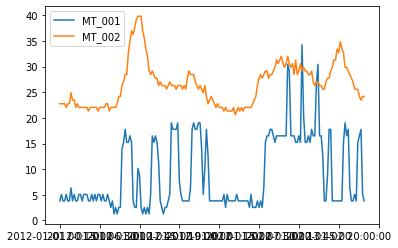

In [224]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

### Plot the 2 days of 2012 for the first 2 clients

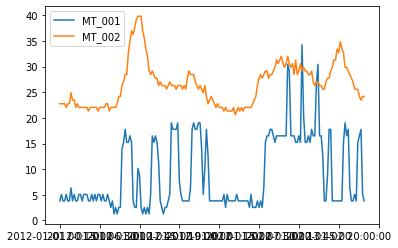

In [225]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### Very Important Note: 
We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [226]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [227]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [228]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [229]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand

# Add data of 2014 at the end of df consist of 2013 data

data_13_14 = data2013.append(data2014) # appending 2013 and 2014

# drop clients with 0 demand
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) 
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


In [230]:
data_13_14.copy()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.000000,38.142620,33.822591,0.000000,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.133250,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.000000,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.000000,175.824176,...,136.985294,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.040080,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.000000,43.946932,35.737077,0.000000,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.642590,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.000000,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.000000,173.076923,...,131.102941,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.040080,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,62.593145,0.000000,39.800995,33.822591,0.000000,41.002278,69.182390,380.191693,11.557789,50.220264,151.832461,27.397260,12.532982,32.921811,299.065421,26.271186,26.187576,95.283927,62.617408,0.000000,111.842105,44.381492,52.587646,27.234637,130.801688,13.769363,125.725338,104.712042,0.000000,175.824176,...,134.044118,55.09375,146.990741,2.910361,43.298969,17.498713,29.245767,92.519685,90.909091,1551.219512,32.967033,328.715365,74.260995,30.674847,63.731170,903.381643,119.675456,0.00000,64.386318,174.129353,648.888889,39.009752,184.733804,19.038076,284.627093,21.317829,719.696970,334.928230,35.612536,163.377193,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,59.612519,0.000000,37.313433,34.460753,0.000000,41.571754,63.791554,351.437700,11.055276,58.149780,167.539267,24.906600,11.873351,32.921811,289.719626,24.576271,27.405603,88.546679,61.991234,0.000000,103.618421,44.381492,53.422371,25.139665,119.549930,15.490534,119.922631,107.329843,0.000000,170.329670,...,125.205882,46.33125,179.398148,2.910361,42.783505,17.498713,29.245767,91.535433,90.909091,1156.097561,32.967033,332.493703,72.819034,30.674847,61.993048,884.057971,120.689655,40.69176,63.883300,174.129353,635.555556,39.009752,187.940988,19.038076,252.663623,30.038760,712.121212,334.928230,35.612536,162.280702,44.254104,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,2

## Getting average curves per client

In [231]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [232]:
data['hour'] = data.index.map(lambda x: x[11:])

In [233]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.0,38.142620,33.822591,0.0,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.13325,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.0,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.0,175.824176,...,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.040080,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.0,43.946932,35.737077,0.0,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.64259,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.0,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.0,173.076923,...,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.040080,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,62.593145,0.0,39.800995,33.822591,0.0,41.002278,69.182390,380.191693,11.557789,50.220264,151.832461,27.39726,12.532982,32.921811,299.065421,26.271186,26.187576,95.283927,62.617408,0.0,111.842105,44.381492,52.587646,27.234637,130.801688,13.769363,125.725338,104.712042,0.0,175.824176,...,55.09375,146.990741,2.910361,43.298969,17.498713,29.245767,92.519685,90.909091,1551.219512,32.967033,328.715365,74.260995,30.674847,63.731170,903.381643,119.675456,0.00000,64.386318,174.129353,648.888889,39.009752,184.733804,19.038076,284.627093,21.317829,719.696970,334.928230,35.612536,163.377193,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [234]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [235]:
average_curves_norm = average_curves/(average_curves.mean())
average_curves_norm

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,1.067727,0.899154,0.594005,0.812633,0.900893,1.139499,0.942227,0.943290,1.071027,1.112666,0.976258,0.826026,1.041795,0.979740,0.950892,1.198976,1.223172,1.135498,0.922252,1.186509,0.956077,1.025583,0.969207,1.309342,1.023562,0.567422,1.092313,0.874111,1.095065,0.945736,...,0.710134,0.567060,0.555638,0.447612,1.029641,0.593204,0.476664,0.540194,0.603108,0.923516,0.603549,0.753769,0.710593,0.261940,0.513765,0.985052,1.080529,1.775050,0.713224,0.319943,0.486279,1.072717,0.826119,0.439183,0.845824,0.372696,0.609931,1.022005,0.602145,0.678209,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,1.010786,0.852811,0.615436,0.806437,0.859391,1.084290,0.903545,0.885129,1.012910,1.075212,0.914584,0.815918,0.978083,0.920760,0.898229,1.145762,1.156713,1.088980,0.901174,1.128949,0.902647,1.003333,0.924322,1.267231,0.977935,0.559656,1.032555,0.831911,1.019462,0.902165,...,0.664985,0.551260,0.567458,0.420764,0.758324,0.415863,0.443297,0.505168,0.583653,0.821088,0.567388,0.605753,0.604099,0.251535,0.437449,0.941051,1.007065,3.023012,0.660610,0.298278,0.461200,1.020400,0.823074,0.417349,0.754324,0.357106,0.549971,0.749683,0.631951,0.578244,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,0.969343,0.838545,0.634072,0.806398,0.828778,1.039392,0.868223,0.850030,0.972363,1.058519,0.876902,0.791083,0.927749,0.888148,0.857783,1.074662,1.096839,1.059499,0.882685,1.089273,0.864340,0.985413,0.898186,1.229638,0.937742,0.548354,0.983462,0.796789,0.972687,0.864359,...,0.648441,0.550678,0.531500,0.397140,0.744830,0.351576,0.437064,0.502555,0.561693,0.714690,0.526866,0.585229,0.535181,0.243245,0.417783,0.872996,0.909448,2.371901,0.551282,0.288425,0.445375,1.007694,0.959523,0.410401,0.662818,0.344339,0.432228,0.579843,0.963986,0.519432,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,0.931357,0.818549,0.604342,0.789818,0.795739,0.993977,0.831421,0.811675,0.933928,1.031928,0.849460,0.722766,0.880511,0.854794,0.831037,1.011779,1.050137,1.033041,0.871205,1.029465,0.831398,0.977535,0.860856,1.205926,0.902852,0.548796,0.956102,0.766022,0.929884,0.842819,...,0.642507,0.548868,0.540927,0.378948,0.726510,0.340744,0.428850,0.499194,0.491703,0.547632,0.380067,0.479870,0.432177,0.236733,0.371677,0.677297,0.639679,2.038595,0.470241,0.281819,0.413709,0.925264,0.996405,0.410675,0.505291,0.317293,0.406430,0.407983,0.835887,0.439098,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,0.898064,0.802658,0.574845,0.763413,0.770768,0.965608,0.800586,0.772275,0.907320,0.992228,0.821972,0.704117,0.838825,0.826522,0.811437,0.960131,0.995524,0.993714,0.853037,1.001223,0.803945,0.997068,0.828038,1.181616,0.866682,0.543934,0.929947,0.751431,0.882536,0.821145,...,0.636550,0.530001,0.551880,0.373950,0.699937

#### Plot the first 2 and last 2 clients

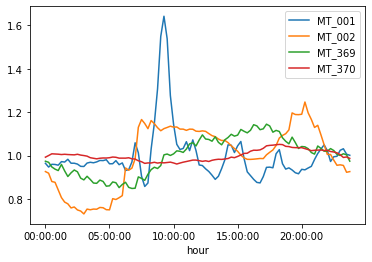

In [236]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [237]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

## Exercise 1:

a. Using the functions described in Module 3, determine what is the optimal number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [238]:
inertias_1 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

In [239]:
inertias_1

[1707.229420029633,
 1175.5272754230882,
 865.9677208804297,
 657.6442657822121,
 553.8272084963303,
 476.48468035158305,
 426.68223434503193,
 391.5105843120735,
 368.04244042810456,
 350.29800203582187,
 330.1187699890719,
 313.91892542640903,
 302.7337864922732,
 293.65866457011754,
 281.7917408771587]

In [240]:
silhouette_avgs

[0.37191838565388774,
 0.42244692513476645,
 0.4296355372224772,
 0.43490147121537626,
 0.4289726637003935,
 0.39571826158729223,
 0.27077911430989965,
 0.2508538342044547,
 0.2415068181174098,
 0.22748152708168196,
 0.19488138331759897,
 0.19885167737714424,
 0.20730197214714066,
 0.2088637230205947]

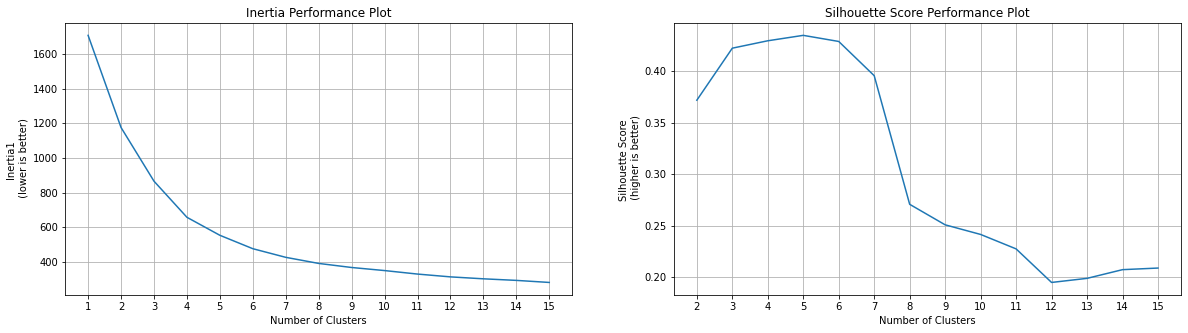

In [241]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(np.arange(1, max_K+1), inertias_1)
plt.title("Inertia Performance Plot")
plt.xticks(np.arange(1, max_K+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia1 \n (lower is better)")
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.arange(2, max_K+1), silhouette_avgs)
plt.title("Silhouette Score Performance Plot")
plt.xticks(np.arange(2, max_K+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score \n (higher is better)")
plt.grid()

plt.show()

In [242]:
#question 5-  solution: 
# the best choice of K is 5 as it provides the largest amount of seperation between cluster (as seen in silhouette_avg = 0.4949) and 
# the the points within clusters are relatively close (inertia= 553).

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [243]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [244]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

In [245]:
daysyear

['tue-2013-01-01',
 'wed-2013-01-02',
 'thu-2013-01-03',
 'fri-2013-01-04',
 'sat-2013-01-05',
 'sun-2013-01-06',
 'mon-2013-01-07',
 'tue-2013-01-08',
 'wed-2013-01-09',
 'thu-2013-01-10',
 'fri-2013-01-11',
 'sat-2013-01-12',
 'sun-2013-01-13',
 'mon-2013-01-14',
 'tue-2013-01-15',
 'wed-2013-01-16',
 'thu-2013-01-17',
 'fri-2013-01-18',
 'sat-2013-01-19',
 'sun-2013-01-20',
 'mon-2013-01-21',
 'tue-2013-01-22',
 'wed-2013-01-23',
 'thu-2013-01-24',
 'fri-2013-01-25',
 'sat-2013-01-26',
 'sun-2013-01-27',
 'mon-2013-01-28',
 'tue-2013-01-29',
 'wed-2013-01-30',
 'thu-2013-01-31',
 'fri-2013-02-01',
 'sat-2013-02-02',
 'sun-2013-02-03',
 'mon-2013-02-04',
 'tue-2013-02-05',
 'wed-2013-02-06',
 'thu-2013-02-07',
 'fri-2013-02-08',
 'sat-2013-02-09',
 'sun-2013-02-10',
 'mon-2013-02-11',
 'tue-2013-02-12',
 'wed-2013-02-13',
 'thu-2013-02-14',
 'fri-2013-02-15',
 'sat-2013-02-16',
 'sun-2013-02-17',
 'mon-2013-02-18',
 'tue-2013-02-19',
 'wed-2013-02-20',
 'thu-2013-02-21',
 'fri-2013-0

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for part (b)

In [246]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

In [247]:
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

In [248]:
inertias_1 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

In [249]:
inertias_1

[6158002.739347876,
 2599946.1576933423,
 2126832.5224953373,
 1864480.7882659277,
 1708131.585853497,
 1591363.1456121658,
 1518731.926086461,
 1443187.9414117965,
 1395623.762149361,
 1354918.5481024964,
 1317464.0813858313,
 1282096.3995526938,
 1258682.3662940958,
 1232953.0227378507,
 1208149.7056146965]

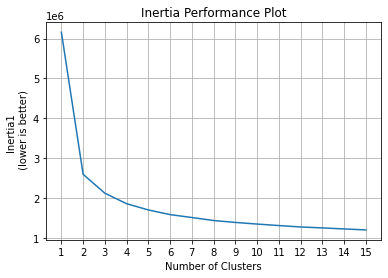

In [250]:
plt.plot(np.arange(1, max_K+1), inertias_1)
plt.title("Inertia Performance Plot")
plt.xticks(np.arange(1, max_K+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia1 \n (lower is better)")
plt.grid()

In [251]:
silhouette_avgs

[0.5011374240143703,
 0.2821977416156188,
 0.2811100481847252,
 0.21965915775778697,
 0.19252971651945266,
 0.18027475571104937,
 0.18373806884169414,
 0.18809023366827565,
 0.17641646008394868,
 0.17410952372263727,
 0.17433896730150597,
 0.16821488389884842,
 0.1485199468436473,
 0.12300392845981299]

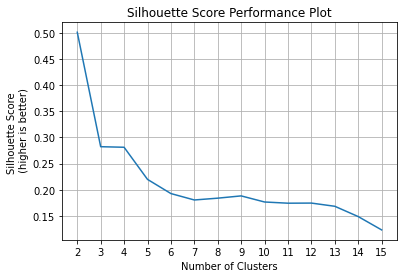

In [252]:
plt.plot(np.arange(2, max_K+1), silhouette_avgs)
plt.title("Silhouette Score Performance Plot")
plt.xticks(np.arange(2, max_K+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score \n (higher is better)")
plt.grid()

In [ ]:
#the best choice of k may be 2

What are the days that are in each cluster?

In [253]:
#make predictions for each day in the dataset between 2013-2014 (X)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.predict(X)
labels

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,

In [254]:
#match the labels to the day the predictions are associated with
cols = {"Day": daysyear, "Cluster": labels}
day_labels = pd.DataFrame(data= cols)

day_labels

,Day,Cluster
0,tue-2013-01-01,0
1,wed-2013-01-02,1
2,thu-2013-01-03,1
3,fri-2013-01-04,1
4,sat-2013-01-05,0
...,...,...
725,sat-2014-12-27,1
726,sun-2014-12-28,0
727,mon-2014-12-29,1
728,tue-2014-12-30,1


In [255]:
#seperate the data into preicted clusters to see if cluster 0 has more weekends than cluster 1
cluster0 = day_labels.loc[day_labels.Cluster==0]
cluster0["Cluster"].count()

219

In [256]:
        #remove the -year-month-day part of the Day column 
import re 

days = [re.sub("[0-9]{2,4}|[-]","",x) for x in cluster0["Day"]]
cluster0.insert(2,"Weekday", days)

In [257]:
cluster0 = cluster0[["Weekday","Cluster"]]
cluster0.groupby(["Weekday"], sort=False).count()

,Cluster
Weekday,
tue,12
sat,58
sun,104
fri,11
mon,12
thu,10
wed,12


In [258]:
#there are more days in the weekend in this cluster 

In [259]:
#check if cluster1 represents weekdays 
cluster1 = day_labels.loc[day_labels.Cluster==1]
cluster1["Cluster"].count()

511

In [260]:
cluster1

,Day,Cluster
1,wed-2013-01-02,1
2,thu-2013-01-03,1
3,fri-2013-01-04,1
6,mon-2013-01-07,1
7,tue-2013-01-08,1
...,...,...
721,tue-2014-12-23,1
724,fri-2014-12-26,1
725,sat-2014-12-27,1
727,mon-2014-12-29,1


In [261]:
days = [re.sub("[0-9]{2,4}|[-]","",x) for x in cluster1["Day"]]
cluster1.insert(2,"Weekday", days)

In [262]:

cluster1 = cluster1[["Weekday","Cluster"]]
cluster1.groupby(["Weekday"], sort= False).count()

,Cluster
Weekday,
wed,93
thu,94
fri,93
mon,92
tue,93
sat,46


There are more days that represent the weekend in Cluster0 than in Cluster1. Moreover cluster1 has more weekdays than it has Weekends. These two facts together could suggest that Cluster0 represents Weekend consumption where as Cluster1 represents weekday consumption. 
